## 0 - Import libraries and define functions

In [23]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')

model_name = 'RandomForestClassifier'


## 1 - Load and prepare the dataset

In [24]:
# Load the saved data, otherwise load the seperate training, validation, test and final evaluation datasets
if os.path.exists(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet')):
    procd_data = pd.read_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))
else:
    procd_train = pd.read_parquet(os.path.join(processed_data_path, 'procd_train.parquet'))
    procd_val = pd.read_parquet(os.path.join(processed_data_path, 'procd_val.parquet'))
    procd_test = pd.read_parquet(os.path.join(processed_data_path, 'procd_test.parquet'))
    procd_final_eval = pd.read_parquet(os.path.join(processed_data_path, 'procd_final_eval.parquet'))

    # Concatenate datasets
    procd_data = pd.concat([procd_train, procd_val, procd_test, procd_final_eval])
    procd_data.reset_index(drop=True, inplace=True)

## 2 - Extract text features for each group

In [25]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

#pyLDAvis.enable_notebook()

### 2.1 - Aggregate text data by group

In [26]:
# Drop the rows with missing 'DIAG1_CAT' and combine the text features,
# if procd_train, procd_val, procd_test and procd_final_eval are loaded
if ('procd_train' in globals()) & ('procd_final_eval' in globals()):
    # Drop the rows with missing 'DIAG1_CAT'
    procd_data = procd_data.dropna(subset=['DIAG1_CAT'])

    # Combine the text features
    procd_data['CombinedText'] = procd_data.apply(lambda x: build_features.combine_textual(x, procd_data.columns.tolist()), axis=1)

procd_data.CombinedText.head()

0    55_year_old Middle_Aged, Unintentional injury/...
1    66_year_old Senior, New problem, Cough, Sympto...
2    1_year_old Child_or_Teenager, Female, New prob...
3    21_year_old Adult, Female, Tobacco_User, New p...
4    84_year_old Senior, Female, Chronic problem, r...
Name: CombinedText, dtype: object

### 2.2 - Preprocess text data

In [27]:
import spacy
import re

In [28]:
# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

custom_stops = ['nos', 'oth', 'nec']
for word in custom_stops:
    nlp.vocab[word].is_stop = True

def preprocess_text(text):
    text = re.sub(r'\bdiabete\b', 'diabetes', text)
    text = re.sub(r'\banom\b', 'anomaly', text)
    text = re.sub(r'\bsho\b', 'shoulder', text)
    text = re.sub(r'\both\b', 'other', text)
    text = re.sub(r'\buns\b', 'unspecified', text)
    
    doc = nlp(text)
    filtered_tokens = [
        token.lemma_.lower() for token in doc
        if (not token.is_stop) and (not token.is_punct)
    ]
    return ' '.join(filtered_tokens)

In [29]:
# Process the combined text,
# if procd_train, procd_val, procd_test and procd_final_eval are loaded
if ('procd_train' in globals()) & ('procd_final_eval' in globals()):
    procd_data['ProcessedText'] = procd_data['CombinedText'].apply(lambda row: preprocess_text(preprocess_text(row)))
    procd_data.to_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))

procd_data.ProcessedText.head()

0    55_year_old middle_age unintentional injury po...
1    66_year_old senior new problem cough symptom r...
2    1_year_old child_or_teenager female new proble...
3    21_year_old adult female tobacco_user new prob...
4    84_year_old senior female chronic problem rout...
Name: ProcessedText, dtype: object

### 2.3 - Calculate term frequencies

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
# Method 1
# Calculate the TF-IDF for each group,
# taking the ProcessedText of each group as the documents,
# and the ProcessedText of the entire dataset as the corpus

group_text = procd_data.groupby('DIAG1_CAT')['ProcessedText'].apply(lambda row: '. '.join(row)).reset_index()

vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(group_text['ProcessedText'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
group_tfidf = pd.concat([group_text['DIAG1_CAT'], tfidf_df], axis=1).groupby('DIAG1_CAT').mean()

group_tfidf.shape

(17, 235)

In [32]:
# Method 2
# Calculate the TF-IDF of each row within each group
# Calculate the average TF-IDF for each group

#vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=None, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(procd_data['ProcessedText'])

# Calculate the average TF-IDF for each cluster
#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#group_tfidf = pd.concat([procd_data['DIAG1_CAT'], tfidf_df], axis=1).groupby('DIAG1_CAT').mean()

#group_tfidf.shape

In [33]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

## 3 - Generate word clouds for each group

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

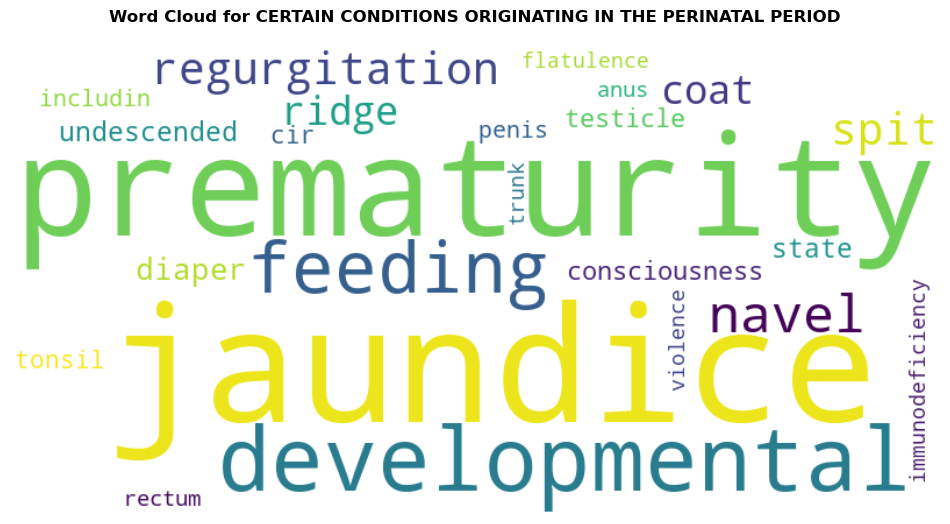

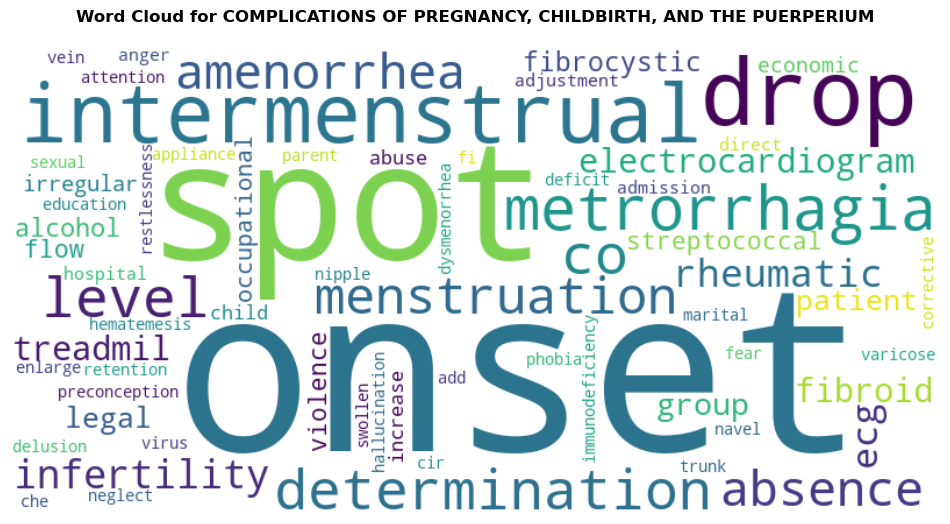

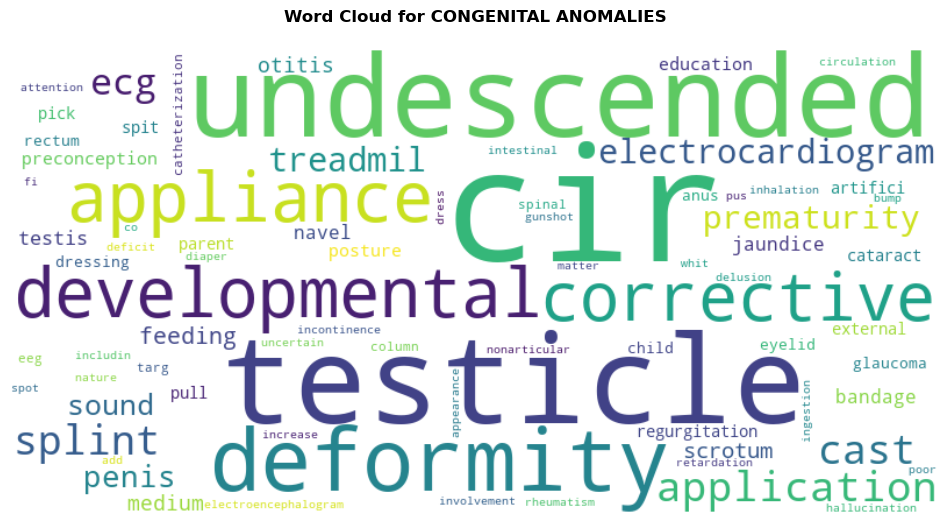

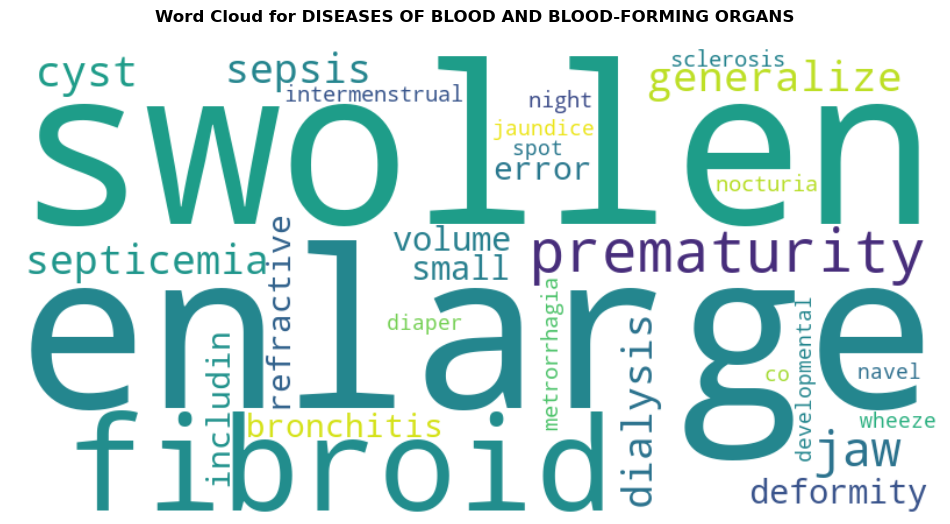

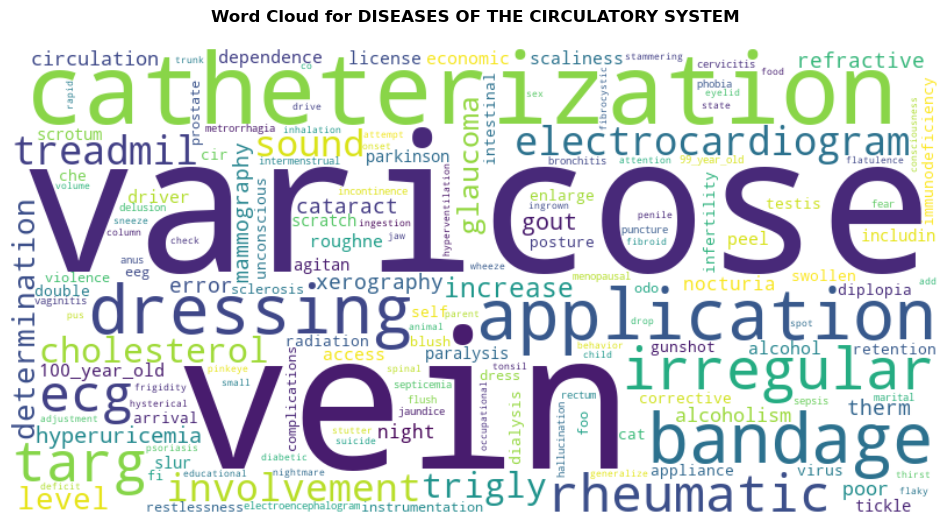

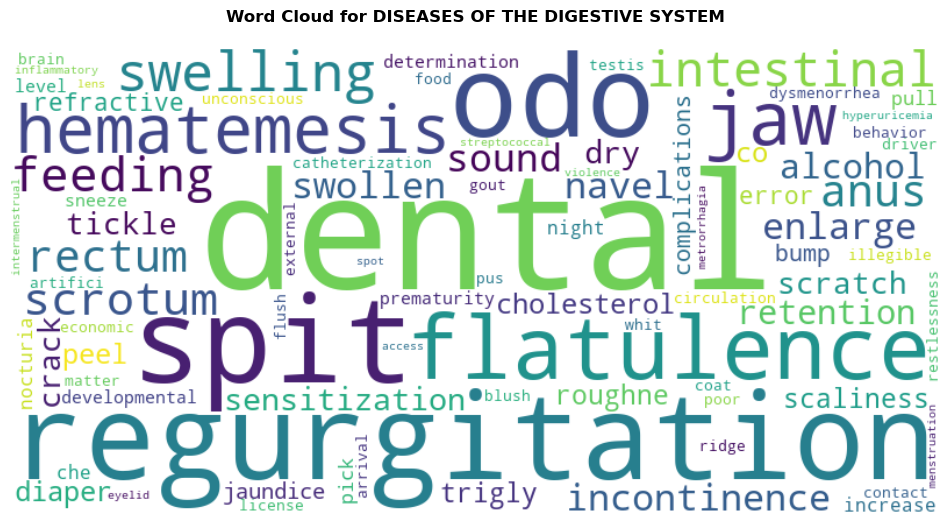

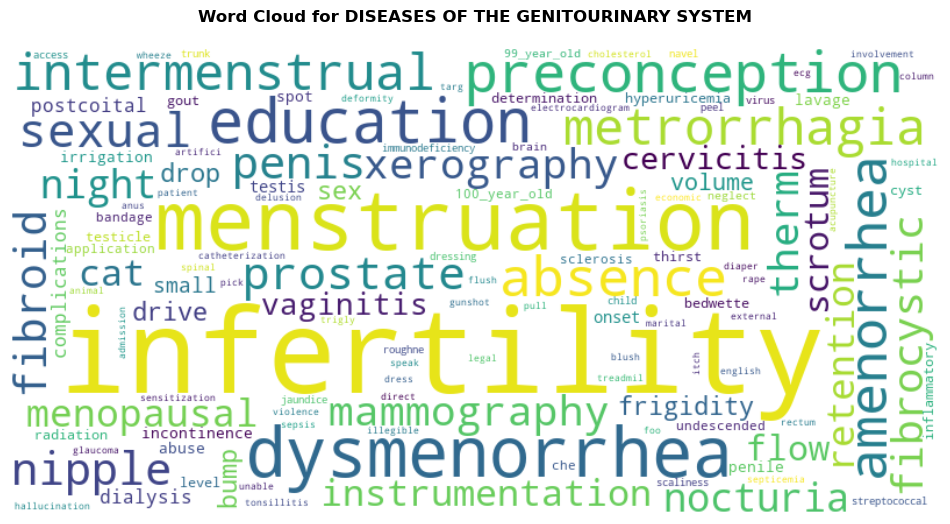

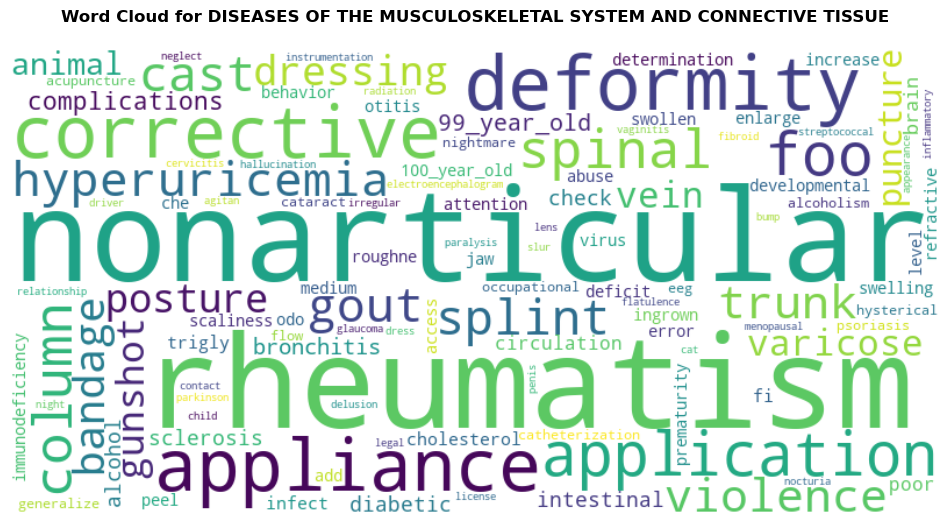

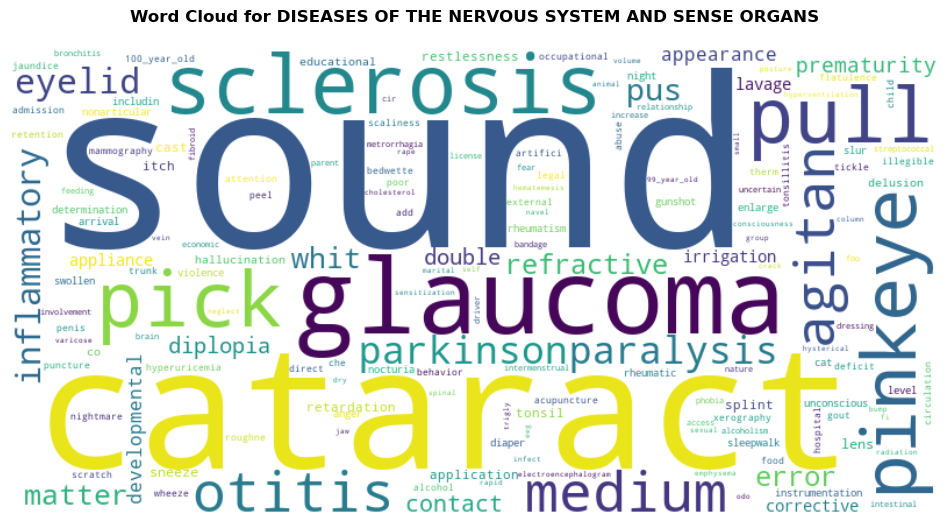

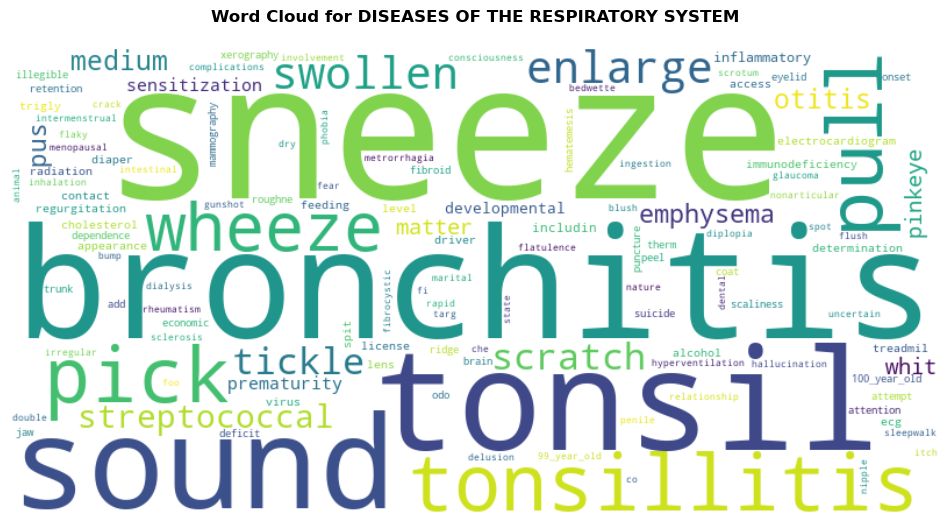

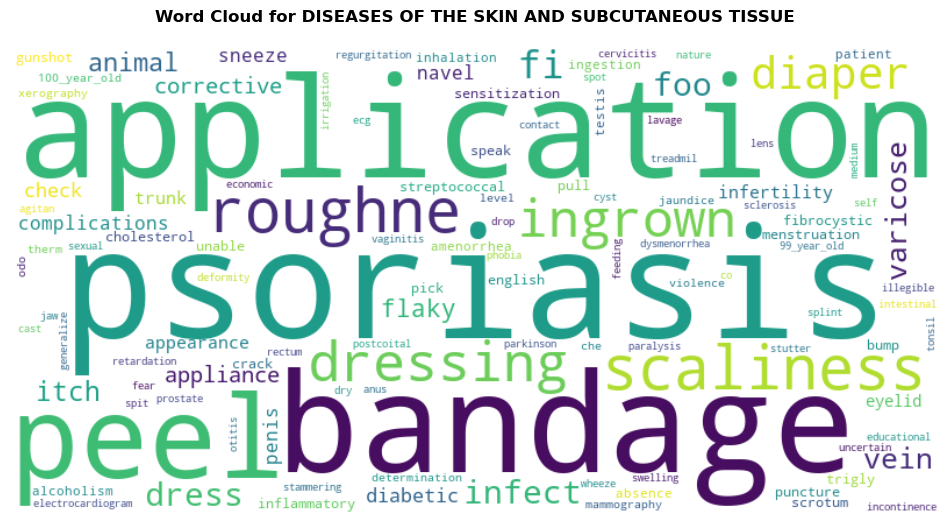

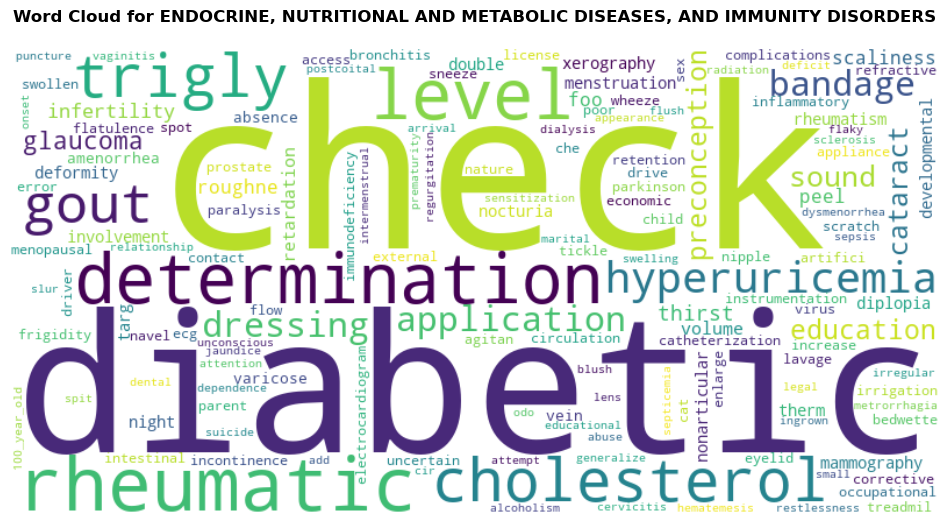

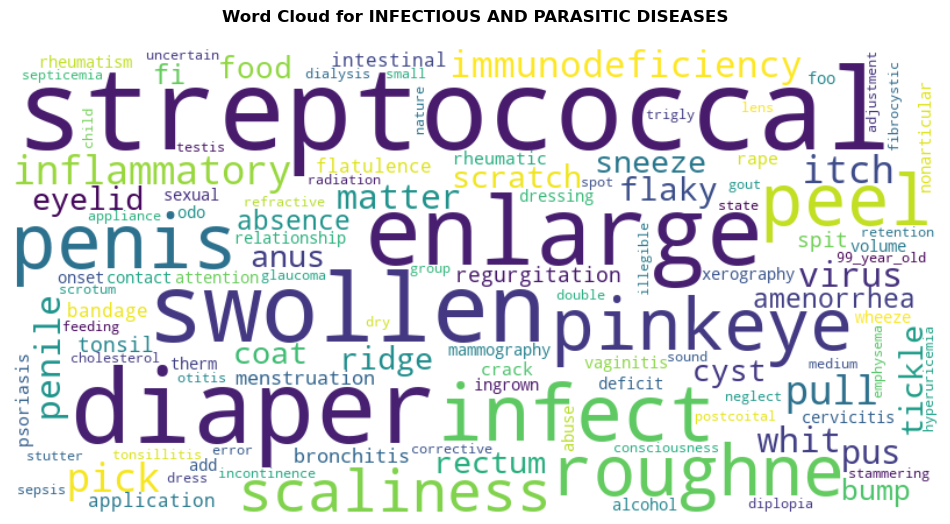

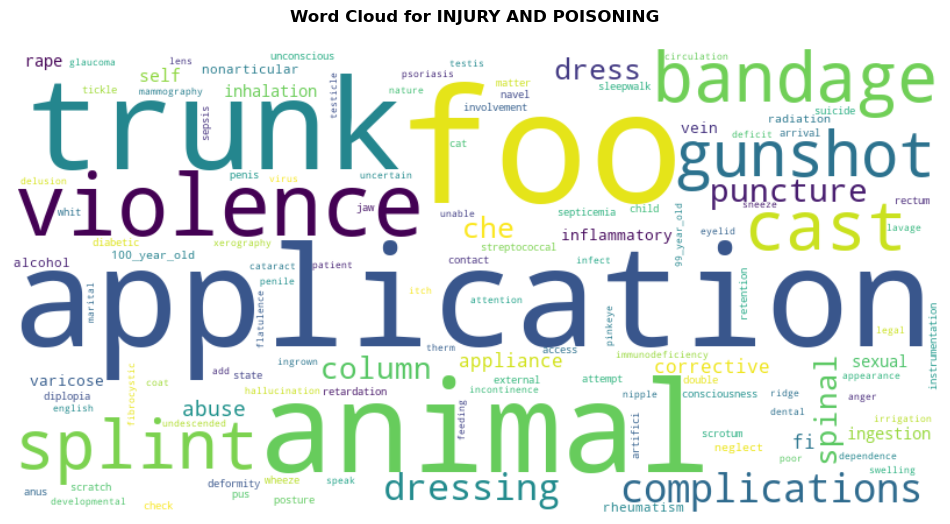

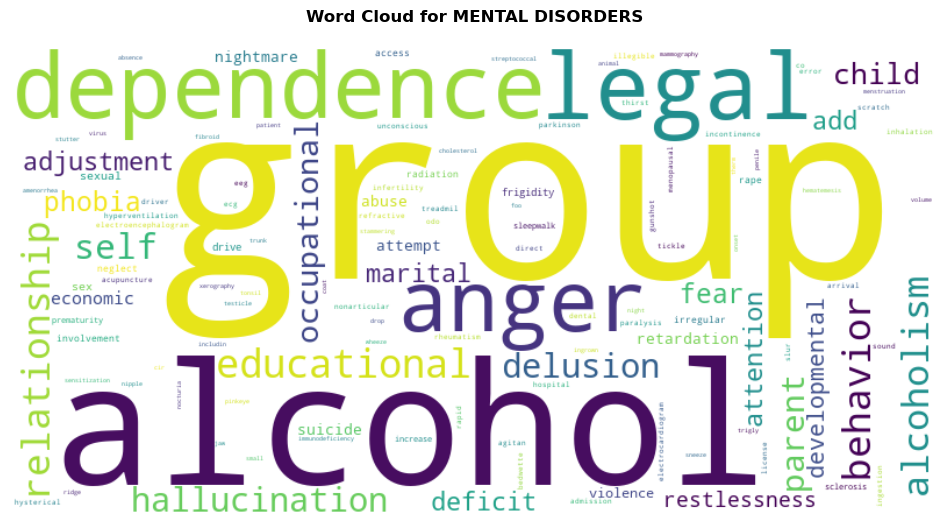

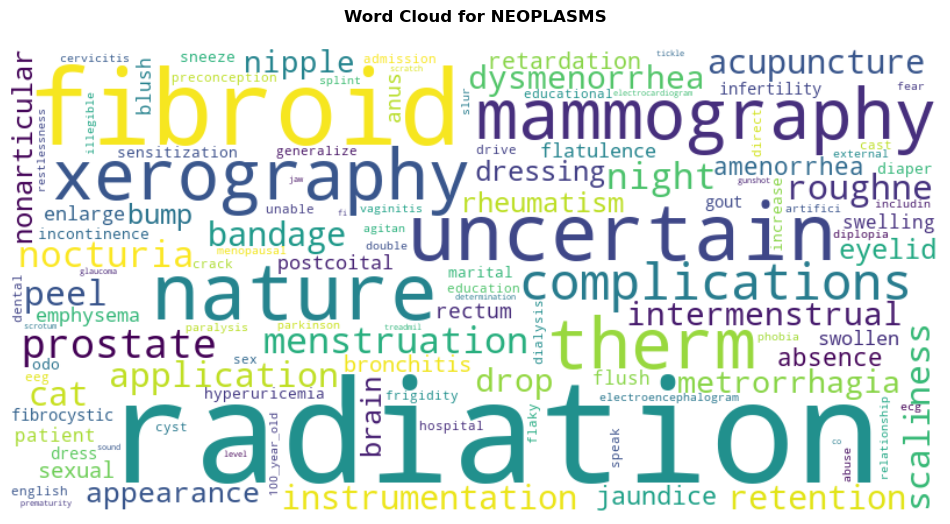

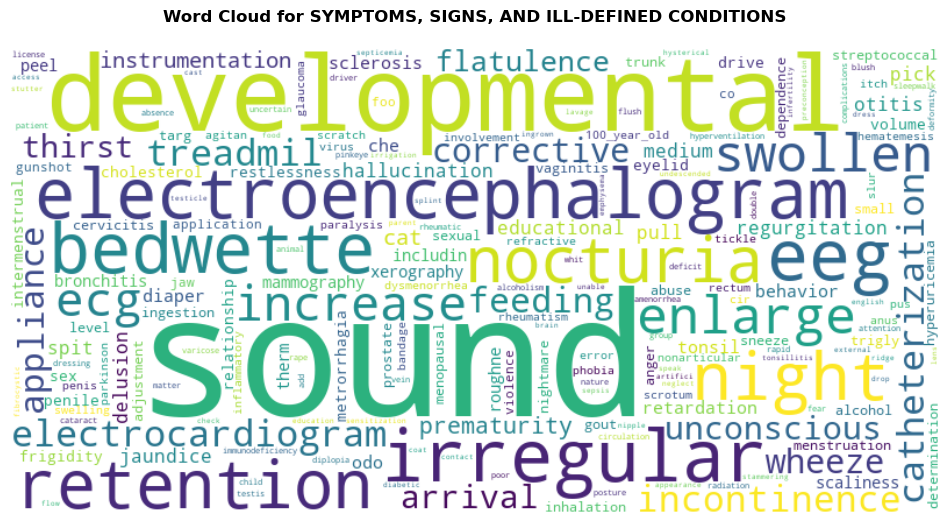

In [35]:
# Plot the word cloud for each 'DIAG1_CAT' based on the average TF-IDF
for category in group_tfidf.index:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(group_tfidf.loc[category])
    plt.figure(figsize=(12, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}', pad=20, weight='bold')
    plt.show()

## 4 - Medical pathways

### 4.1 - Load and concatenate the datasets

In [36]:
# 'diagnostic/screening services
examination = ['BREAST', 'PELVIC', 'PELVIC', 'SKIN', 'DEPRESS']
print('examination:', examination)

imaging = ['XRAY', 'BONEDENS', 'CATSCAN', 'ULTRASND', 'MAMMO', 'MRI']
print('imaging:', imaging)

bloodTest = ['CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA']
print('bloodTest:', bloodTest)

otherTest = ['BIOPSY', 'CHLAMYD', 'EKG', 'HPVDNA', 'PAP', 'PREGTEST', 'URINE']
print('otherTest:', otherTest)

examination: ['BREAST', 'PELVIC', 'PELVIC', 'SKIN', 'DEPRESS']
imaging: ['XRAY', 'BONEDENS', 'CATSCAN', 'ULTRASND', 'MAMMO', 'MRI']
bloodTest: ['CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA']
otherTest: ['BIOPSY', 'CHLAMYD', 'EKG', 'HPVDNA', 'PAP', 'PREGTEST', 'URINE']


### 4.1 - Possibilities of sevices arranged for each 'DIAG1_CAT1' group

In [37]:
# Check the count of missing values for each feature in 'binary_services'
len(examination + imaging + bloodTest + otherTest)

23

In [38]:
procd_data.columns

Index(['DIAG1_CAT', 'AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR',
       'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF',
       'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT',
       'DIAG2_TEXT', 'DIAG3_TEXT', 'RFV1_MOD1', 'RFV1_MOD2', 'RFV2_MOD1',
       'RFV2_MOD2', 'RFV3_MOD1', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP',
       'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'TEXT', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9', 'CombinedText', 'ProcessedText'],
      dtype='object')

In [39]:
procd_data.CombinedText.iloc[30]

'54_year_old Middle_Aged, Female, New problem, Throat soreness, Symptoms Referable to the Respiratory System, SYMPTOM MODULE, Other and unspecified diagnostic tests, Diagnostic Tests, DIAGNOSTIC, SCREENING AND PREVENTIVE MODULE, EKG, ECG, electrocardiogram, treadmil..., Diagnostic Tests, DIAGNOSTIC, SCREENING AND PREVENTIVE MODULE, Normal_weight, Prehypertension, Normal_diastolic_blood_pressure'

In [40]:
procd_data.RFV1_TEXT.iloc[30]

'Throat soreness'

In [41]:
procd_data.iloc[30, :45]

DIAG1_CAT               DISEASES OF THE RESPIRATORY SYSTEM
AGE                                                     54
AGER                                                     4
SEX                                                      1
USETOBAC                                                 1
INJDET                                                  -9
MAJOR                                                    1
RFV1                                                 14551
RFV2                                                 33700
RFV3                                                 33500
PASTVIS                                                1.0
HTIN                                                  69.0
WTLB                                                 157.0
BMI                                                  23.18
TEMPF                                                  NaN
BPSYS                                                134.0
BPDIAS                                                78

In [50]:
# Check the distribution and balance of the target variable
procd_data.DIAG1_CAT.value_counts(normalize=True)

# Plot the distribution of the target variable with the 
alt.Chart(procd_data).mark_bar().encode(
    x=alt.X('DIAG1_CAT', title='Diagnosis Category'),
    y=alt.Y('count()', title='Count'),
    color=alt.Color('DIAG1_CAT', title='Diagnosis Category')
).properties(
    title='Distribution of Diagnosis Category',
    width=800,
    height=400
)

build_features.chart(
    procd_data,
    x = 'count(DIAG1_CAT):Q',
    y = 'DIAG1_CAT:N',
    title = 'Imbalanced Distribution of Classification of Diseases and Injuries',
).mark_bar().configure_axisY(
    labelLimit=500, title=None
).configure_axisX(
    labels=False, title=None
).properties(width=300, height=500)

alt.Chart(...)